#Part 1

Create function to pull data file from .zip

The data set we will be applying this framework to throughout this series is the Environmental Protection Agency's Vehicle Fuel Economy data set. 

In [1]:
import os
import zipfile
import requests

def download_data(url, name, path='data'):
    if not os.path.exists(path):
        os.mkdir(path)

    response = requests.get(url)
    with open(os.path.join(path, name), 'wb') as f:
        f.write(response.content)

    z = zipfile.ZipFile(os.path.join(path, 'vehicles.zip'))
    z.extractall(path)

VEHICLES = 'http://bit.ly/ddl-cars'

download_data(VEHICLES, 'vehicles.zip')

In [2]:
import pandas as pd

path = 'data'

vehicles = pd.read_csv(os.path.join(path, 'vehicles.csv'))

/usr/local/src/bluemix_jupyter_bundle.v71/notebook/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (70,71,72,73,74,76,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Clean data - pull interesting columns, drop duplicated data points, drop n/a's, sort data by make, model, and year

In [3]:
select_columns = ['make', 'model', 'year', 'displ', 'cylinders', 'trany', 'drive', 'VClass','fuelType','barrels08', 'city08', 'highway08', 'comb08', 'co2TailpipeGpm', 'fuelCost08']

vehicles = vehicles[select_columns][vehicles.year <= 2016].drop_duplicates().dropna()

vehicles = vehicles.sort_values(['make', 'model', 'year'])

In [4]:
vehicles.head()

,make,model,year,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,comb08,co2TailpipeGpm,fuelCost08
19316,AM General,DJ Po Vehicle 2WD,1984,2.5,4,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,19.388824,18,17,17,522.764706,1950
19314,AM General,FJ8c Post Office,1984,4.2,6,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,25.354615,13,13,13,683.615385,2550
358,AM General,Post Office DJ5 2WD,1985,2.5,4,Automatic 3-spd,Rear-Wheel Drive,Special Purpose Vehicle 2WD,Regular,20.600625,16,17,16,555.437500,2100
369,AM General,Post Office DJ8 2WD,1985,4.2,6,Automatic 3-spd,Rear-Wheel Drive,Special Purpose Vehicle 2WD,Regular,25.354615,13,13,13,683.615385,2550
25797,ASC Incorporated,GNX,1987,3.8,6,Automatic 4-spd,Rear-Wheel Drive,Midsize Cars,Premium,20.600625,14,21,16,555.437500,2550


In [5]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35095 entries, 19316 to 29609
Data columns (total 15 columns):
make              35095 non-null object
model             35095 non-null object
year              35095 non-null int64
displ             35095 non-null float64
cylinders         35095 non-null float64
trany             35095 non-null object
drive             35095 non-null object
VClass            35095 non-null object
fuelType          35095 non-null object
barrels08         35095 non-null float64
city08            35095 non-null int64
highway08         35095 non-null int64
comb08            35095 non-null int64
co2TailpipeGpm    35095 non-null float64
fuelCost08        35095 non-null int64
dtypes: float64(4), int64(5), object(6)
memory usage: 4.3+ MB


Rename columns to make more readable

In [6]:
vehicles.columns = ['Make','Model','Year','Engine Displacement','Cylinders',
                    'Transmission','Drivetrain','Vehicle Class','Fuel Type',
                    'Fuel Barrels/Year','City MPG','Highway MPG','Combined MPG',
                    'CO2 Emission Grams/Mile','Fuel Cost/Year']

#Part 2

#Categorical Variables

Looking to simplify data - create higher level categorical variables or remove complexity from data

In [7]:
def unique_col_values(df):
    for column in df:
        print("{} | {} | {}".format(
            df[column].name, len(df[column].unique()), df[column].dtype
        ))

unique_col_values(vehicles)

Make | 126 | object
Model | 3490 | object
Year | 33 | int64
Engine Displacement | 65 | float64
Cylinders | 9 | float64
Transmission | 44 | object
Drivetrain | 7 | object
Vehicle Class | 34 | object
Fuel Type | 13 | object
Fuel Barrels/Year | 116 | float64
City MPG | 48 | int64
Highway MPG | 49 | int64
Combined MPG | 46 | int64
CO2 Emission Grams/Mile | 550 | float64
Fuel Cost/Year | 55 | int64


Ex of simplfying data - Transmission: there are 44 types of transmission - they can be broken into Automatic and Manual

In [8]:
len(vehicles.Transmission.unique())

44

In [9]:
vehicles.Transmission.value_counts() 

Automatic 4-spd                     10582
Manual 5-spd                         7764
Automatic 3-spd                      2597
Automatic (S6)                       2455
Manual 6-spd                         2336
Automatic 5-spd                      2171
Automatic 6-spd                      1351
Manual 4-spd                         1306
Automatic (S5)                        822
Automatic (S8)                        774
Automatic (variable gear ratios)      643
Automatic 7-spd                       630
Automatic (S7)                        238
Automatic (S4)                        229
Auto(AM-S7)                           211
Automatic 8-spd                       207
Auto(AV-S6)                           135
Auto(AM7)                             124
Auto(AM6)                             103
Auto(AM-S6)                            82
Manual 3-spd                           74
Manual 7-spd                           56
Auto(AV-S7)                            54
Automatic 9-spd                   

Create "Transmission Type" column, fill column with AUTOMATIC or MANUAL depending on entry in "Transmission" column

In [10]:
AUTOMATIC = "Automatic"
MANUAL = "Manual"

vehicles.loc[vehicles['Transmission'].str.startswith('A'),
             'Transmission Type'] = AUTOMATIC

vehicles.loc[vehicles['Transmission'].str.startswith('M'),
             'Transmission Type'] = MANUAL

Create "Vehicle Category" column, fill new column with small, midsize, or large based on entry in Vehicle Class

In [11]:
small = ['Compact Cars','Subcompact Cars','Two Seaters','Minicompact Cars']
midsize = ['Midsize Cars']
large = ['Large Cars']

vehicles.loc[vehicles['Vehicle Class'].isin(small), 
             'Vehicle Category'] = 'Small Cars'

vehicles.loc[vehicles['Vehicle Class'].isin(midsize), 
             'Vehicle Category'] = 'Midsize Cars'

vehicles.loc[vehicles['Vehicle Class'].isin(large), 
             'Vehicle Category'] = 'Large Cars'

vehicles.loc[vehicles['Vehicle Class'].str.contains('Station'), 
             'Vehicle Category'] = 'Station Wagons'

vehicles.loc[vehicles['Vehicle Class'].str.contains('Truck'), 
             'Vehicle Category'] = 'Pickup Trucks'

vehicles.loc[vehicles['Vehicle Class'].str.contains('Special Purpose'), 
             'Vehicle Category'] = 'Special Purpose'

vehicles.loc[vehicles['Vehicle Class'].str.contains('Sport Utility'), 
             'Vehicle Category'] = 'Sport Utility'

vehicles.loc[(vehicles['Vehicle Class'].str.lower().str.contains('van')),
             'Vehicle Category'] = 'Vans & Minivans'

Combine Make and Model columns into a new column - Model Type: generalized car model

Ex) Categorize all Chevrolet Suburban C1500 2WD vehicles and all Chevrolet Suburban K1500 4WD vehicles as simply Chevrolet Suburbans

In [12]:
vehicles['Model Type'] = (vehicles['Make'] + " " +
                          vehicles['Model'].str.split().str.get(0))

In [13]:
vehicles['Fuel Type'].value_counts()

Regular                        23208
Premium                         9509
Gasoline or E85                 1157
Diesel                           906
Premium or E85                   116
Midgrade                          64
CNG                               60
Gasoline or natural gas           20
Premium Gas or Electricity        16
Premium and Electricity           16
Regular Gas and Electricity       14
Gasoline or propane                8
Regular Gas or Electricity         1
Name: Fuel Type, dtype: int64

Create a column for each Fuel Type - create categorical variables for each fuel type

How: Default each value in new columns (Gas, Ethanol, Electricity, Propane, Natural Gas) to 0, Put a 1 in the appropriate column if a Fuel Type is correct for a given category

Ex) If Fuel Type = "E85" then put 1 in Ethanol column

In [14]:
vehicles['Gas'] = 0
vehicles['Ethanol'] = 0
vehicles['Electric'] = 0
vehicles['Propane'] = 0
vehicles['Natural Gas'] = 0

vehicles.loc[vehicles['Fuel Type'].str.contains(
        'Regular|Gasoline|Midgrade|Premium|Diesel'),'Gas'] = 1

vehicles.loc[vehicles['Fuel Type'].str.contains('E85'),'Ethanol'] = 1

vehicles.loc[vehicles['Fuel Type'].str.contains('Electricity'),'Electric'] = 1

vehicles.loc[vehicles['Fuel Type'].str.contains('propane'),'Propane'] = 1

vehicles.loc[vehicles['Fuel Type'].str.contains('natural|CNG'),'Natural Gas'] = 1

Create Gas Type Column to further categorize gas types based on data in Fuel Type column

In [15]:
vehicles.loc[vehicles['Fuel Type'].str.contains(
        'Regular|Gasoline'),'Gas Type'] = 'Regular'

vehicles.loc[vehicles['Fuel Type'] == 'Midgrade',
             'Gas Type'] = 'Midgrade'

vehicles.loc[vehicles['Fuel Type'].str.contains('Premium'),
             'Gas Type'] = 'Premium'

vehicles.loc[vehicles['Fuel Type'] == 'Diesel',
             'Gas Type'] = 'Diesel'

vehicles.loc[vehicles['Fuel Type'].str.contains('natural|CNG'),
             'Gas Type'] = 'Natural'

#Binning

When working with continous variables, bin them to make them easier - def of bin: combine into discrete buckets by creating ranges

Ex) In marketing - create customer cohorts to buckets consumers into similar joining times

Use qcut function - pandas.qcut(Series, # of quintiles/buckets, labels)

In [16]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35095 entries, 19316 to 29609
Data columns (total 24 columns):
Make                       35095 non-null object
Model                      35095 non-null object
Year                       35095 non-null int64
Engine Displacement        35095 non-null float64
Cylinders                  35095 non-null float64
Transmission               35095 non-null object
Drivetrain                 35095 non-null object
Vehicle Class              35095 non-null object
Fuel Type                  35095 non-null object
Fuel Barrels/Year          35095 non-null float64
City MPG                   35095 non-null int64
Highway MPG                35095 non-null int64
Combined MPG               35095 non-null int64
CO2 Emission Grams/Mile    35095 non-null float64
Fuel Cost/Year             35095 non-null int64
Transmission Type          35095 non-null object
Vehicle Category           35095 non-null object
Model Type                 35095 non-null object
Gas   

Combined MPG, Engine Size, Emissions, Fuel Costs - bucket into 5 categories 

In [17]:
efficiency_categories = ['Very Low Efficiency', 'Low Efficiency',
                         'Moderate Efficiency','High Efficiency',
                         'Very High Efficiency']

vehicles['Fuel Efficiency'] = pd.qcut(vehicles['Combined MPG'],
                                      5, efficiency_categories)

In [18]:
engine_categories = ['Very Small Engine', 'Small Engine','Moderate Engine',
                     'Large Engine', 'Very Large Engine']

vehicles['Engine Size'] = pd.qcut(vehicles['Engine Displacement'],
                                  5, engine_categories)

In [19]:
emission_categories = ['Very Low Emissions', 'Low Emissions',
                        'Moderate Emissions','High Emissions',
                        'Very High Emissions']

vehicles['Emissions'] = pd.qcut(vehicles['CO2 Emission Grams/Mile'],
                                 5, emission_categories)

In [20]:
fuelcost_categories = ['Very Low Fuel Cost', 'Low Fuel Cost',
                       'Moderate Fuel Cost','High Fuel Cost',
                       'Very High Fuel Cost']

vehicles['Fuel Cost'] = pd.qcut(vehicles['Fuel Cost/Year'],
                                5, fuelcost_categories)

#Clustering 

Create new features from related variables, use numerical variables ONLY

In [21]:
cluster_columns = ['Engine Displacement','Cylinders','Fuel Barrels/Year',
                   'City MPG','Highway MPG','Combined MPG',
                   'CO2 Emission Grams/Mile', 'Fuel Cost/Year']

Scale numerical values so that they retain their distribution but are numbers between 0 and 1 (Purpose: mathematical convenience?)

In [22]:
from sklearn import preprocessing
scaler = preprocessing.MaxAbsScaler()

vehicle_clusters = scaler.fit_transform(vehicles[cluster_columns])
vehicle_clusters = pd.DataFrame(vehicle_clusters, columns=cluster_columns)

K means cluster to create groups - create new features based on group characteristics

Explanation: https://www.quora.com/What-is-a-k-means-algorithm

In [23]:
from sklearn.cluster import KMeans

def kmeans_cluster(df, n_clusters=2):
    model = KMeans(n_clusters=n_clusters, random_state=1)
    clusters = model.fit_predict(df)
    cluster_results = df.copy()
    cluster_results['Cluster'] = clusters
    return cluster_results

In [24]:
def summarize_clustering(results):
    cluster_size = results.groupby(['Cluster']).size().reset_index()
    cluster_size.columns = ['Cluster', 'Count']
    cluster_means = results.groupby(['Cluster'], as_index=False).mean()
    cluster_summary = pd.merge(cluster_size, cluster_means, on='Cluster')
    return cluster_summary

Creates 4 clusters (based on iteration to see the number of clusters that is mutually exclusive,collectively exhaustive - this part is more art than science...)

In [25]:
cluster_results = kmeans_cluster(vehicle_clusters, 4)
cluster_summary = summarize_clustering(cluster_results)

In [26]:
cluster_summary

,Cluster,Count,Engine Displacement,Cylinders,Fuel Barrels/Year,City MPG,Highway MPG,Combined MPG,CO2 Emission Grams/Mile,Fuel Cost/Year
0,0,8195,0.230890,0.251411,0.266962,0.413265,0.515462,0.478114,0.267262,0.227753
1,1,8188,0.513292,0.428325,0.423538,0.253255,0.329058,0.296837,0.425091,0.370426
2,2,13603,0.330854,0.322369,0.352043,0.303940,0.397599,0.357866,0.352017,0.308864
3,3,5109,0.659905,0.527770,0.533567,0.204116,0.266030,0.239825,0.533659,0.465684


Visualization of clustering

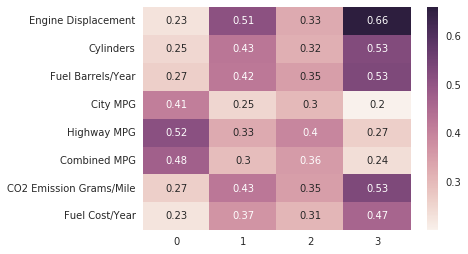

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.heatmap(cluster_summary[cluster_columns].transpose(), annot=True)

Create descriptive labels for clusters - Remember the graph shows rescaled, average values for given variables.

Ex - Cluster 3 has a large amount of engine displacement, lots of cylinders, lost of emissions, and high fuel costs -> "Large Inefficient"

In [28]:
cluster_results['Cluster Name'] = ''
cluster_results['Cluster Name'][cluster_results['Cluster']==2] = 'Midsized Balanced'
cluster_results['Cluster Name'][cluster_results['Cluster']==3] = 'Large Inefficient'
cluster_results['Cluster Name'][cluster_results['Cluster']==1] = 'Large Moderately Efficient'
cluster_results['Cluster Name'][cluster_results['Cluster']==0] = 'Small Very Efficient'

vehicles = vehicles.reset_index().drop('index', axis=1)
vehicles['Cluster Name'] = cluster_results['Cluster Name']

/usr/local/src/bluemix_jupyter_bundle.v71/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/src/bluemix_jupyter_bundle.v71/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/src/bluemix_jupyter_bundle.v71/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

In [29]:
vehicles.head()

,Make,Model,Year,Engine Displacement,Cylinders,Transmission,Drivetrain,Vehicle Class,Fuel Type,Fuel Barrels/Year,...,Ethanol,Electric,Propane,Natural Gas,Gas Type,Fuel Efficiency,Engine Size,Emissions,Fuel Cost,Cluster Name
0,AM General,DJ Po Vehicle 2WD,1984,2.5,4,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,19.388824,...,0,0,0,0,Regular,Low Efficiency,Small Engine,High Emissions,Moderate Fuel Cost,Midsized Balanced
1,AM General,FJ8c Post Office,1984,4.2,6,Automatic 3-spd,2-Wheel Drive,Special Purpose Vehicle 2WD,Regular,25.354615,...,0,0,0,0,Regular,Very Low Efficiency,Large Engine,Very High Emissions,Very High Fuel Cost,Large Moderately Efficient
2,AM General,Post Office DJ5 2WD,1985,2.5,4,Automatic 3-spd,Rear-Wheel Drive,Special Purpose Vehicle 2WD,Regular,20.600625,...,0,0,0,0,Regular,Very Low Efficiency,Small Engine,High Emissions,High Fuel Cost,Midsized Balanced
3,AM General,Post Office DJ8 2WD,1985,4.2,6,Automatic 3-spd,Rear-Wheel Drive,Special Purpose Vehicle 2WD,Regular,25.354615,...,0,0,0,0,Regular,Very Low Efficiency,Large Engine,Very High Emissions,Very High Fuel Cost,Large Moderately Efficient
4,ASC Incorporated,GNX,1987,3.8,6,Automatic 4-spd,Rear-Wheel Drive,Midsize Cars,Premium,20.600625,...,0,0,0,0,Premium,Very Low Efficiency,Large Engine,High Emissions,Very High Fuel Cost,Large Moderately Efficient


#Part 3 Exploratory Data Analysis

Making Our Data Smaller: Filter + Aggregate
One of the fundamental ways to extract insights from a data set is to reduce the size of the data so that you can look at just a piece of it at a time. There are two ways to do this: filtering and aggregating. With filtering, you are essentially removing either rows or columns (or both rows and columns) in order to focus on a subset of the data that interests you. With aggregation, the objective is to group records in your data set that have similar categorical attributes and then perform some calculation (count, sum, mean, etc.) on one or more numerical fields so that you can observe and identify differences between records that fall into each group.

To begin filtering and aggregating our data set, we could write a function like the one below to aggregate based on a group_field that we provide, counting the number of rows in each group. To make things more intuitive and easier to interpret, we will also sort the data from most frequent to least and format it in a pandas data frame with appropriate column names

In [30]:
def agg_count(df, group_field):
    grouped = df.groupby(group_field, as_index=False).size()
    grouped.sort(ascending = False)

    grouped = pd.DataFrame(grouped).reset_index()
    grouped.columns = [group_field, 'Count']
    return grouped

Now that we have this function in our toolkit, let's use it. Suppose we were looking at the Vehicle Category field in our data set and were curious about the number of vehicles in each category that were manufactured last year (2016). Here is how we would filter the data and use the agg_count function to transform it to show what we wanted to know.

In [31]:
vehicles_2016 = vehicles[vehicles['Year']==2016]
category_counts = agg_count(vehicles_2016, 'Vehicle Category')

/usr/local/src/bluemix_jupyter_bundle.v71/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  app.launch_new_instance()


This gives us what we want in tabular form, but we could take it a step further and visualize it with a horizontal bar chart.

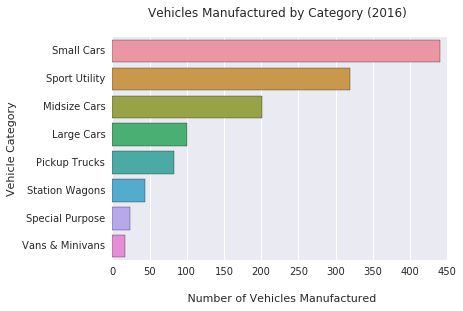

In [32]:
ax = sns.barplot(data=category_counts, x='Count', y='Vehicle Category')
ax.set(xlabel='\n Number of Vehicles Manufactured')
sns.plt.title('Vehicles Manufactured by Category (2016) \n')

Now that we know how to do this, we can filter, aggregate, and plot just about anything in our data set with just a few lines of code. For example, here is the same metric but filtered for a different year (1985).

/usr/local/src/bluemix_jupyter_bundle.v71/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  app.launch_new_instance()


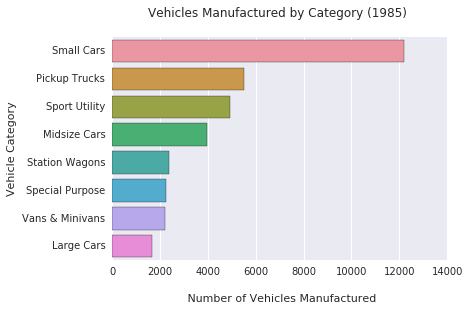

In [33]:
vehicles_1985 = vehicles[vehicles['Year']==1985]
category_counts = agg_count(vehicles, 'Vehicle Category')

ax = sns.barplot(data=category_counts, x='Count', y='Vehicle Category')
ax.set(xlabel='\n Number of Vehicles Manufactured')
sns.plt.title('Vehicles Manufactured by Category (1985) \n')

If we wanted to stick with the year 2016 but drill down to the more granular Vehicle Class, we could do that as well.

/usr/local/src/bluemix_jupyter_bundle.v71/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  app.launch_new_instance()


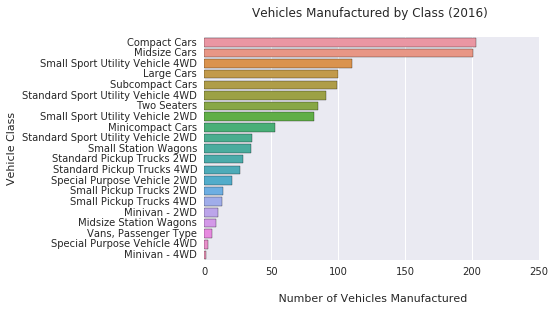

In [34]:
class_counts = agg_count(vehicles_2016, 'Vehicle Class')

ax = sns.barplot(data=class_counts, x='Count', y='Vehicle Class')
ax.set(xlabel='\n Number of Vehicles Manufactured')
sns.plt.title('Vehicles Manufactured by Class (2016) \n')

We could also look at vehicle counts by manufacturer

/usr/local/src/bluemix_jupyter_bundle.v71/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  app.launch_new_instance()


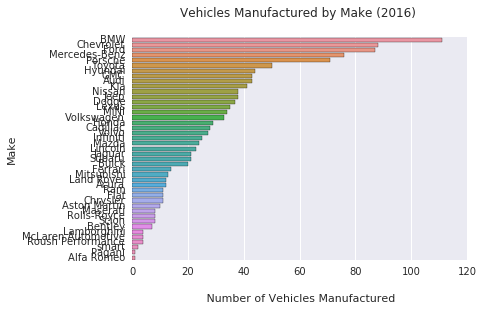

In [35]:
make_counts = agg_count(vehicles_2016, 'Make')

ax = sns.barplot(data=make_counts, x='Count', y='Make')
ax.set(xlabel='\n Number of Vehicles Manufactured')
sns.plt.title('Vehicles Manufactured by Make (2016) \n')

What if we wanted to filter by something other than the year? We could do that by simply creating a different filtered data frame and passing that to our agg_count function. Below, instead of filtering by Year, I've filtered on the Fuel Efficiency field, which contains the fuel efficiency quintiles we generated in the last post. 

Let's choose the Very High Efficiency value so that we can see how many very efficient vehicles each manufacturer has made.

/usr/local/src/bluemix_jupyter_bundle.v71/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  app.launch_new_instance()


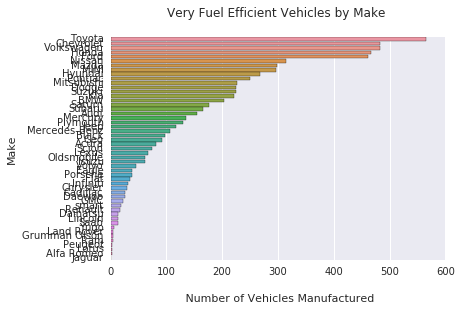

In [36]:
very_efficient = vehicles[vehicles['Fuel Efficiency']=='Very High Efficiency']
make_counts = agg_count(very_efficient, 'Make')

ax = sns.barplot(data=make_counts, x='Count', y='Make')
ax.set(xlabel='\n Number of Vehicles Manufactured')
sns.plt.title('Very Fuel Efficient Vehicles by Make \n')

What if we wanted to perform some other calculation, such as averaging, instead of counting the number of records that fall into each group? We can just create a new function called agg_avg that calculates the mean of a designated numerical field.

In [37]:
def agg_avg(df, group_field, calc_field):
    grouped = df.groupby(group_field, as_index=False)[calc_field].mean()
    grouped = grouped.sort(calc_field, ascending = False)
    grouped.columns = [group_field, 'Avg ' + str(calc_field)]
    return grouped

We can then simply swap out the agg_count function with our new agg_avg function and indicate what field we would like to use for our calculation. Below is an example showing the average fuel efficiency, represented by the Combined MPG field, by vehicle category.

/usr/local/src/bluemix_jupyter_bundle.v71/notebook/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


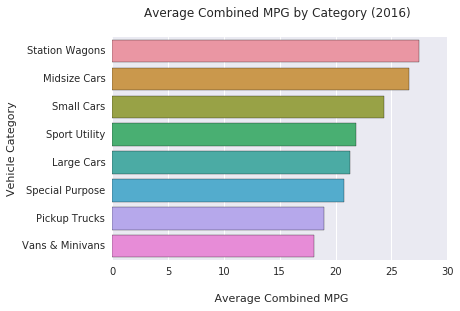

In [38]:
category_avg_mpg = agg_avg(vehicles_2016, 'Vehicle Category', 'Combined MPG')

ax = sns.barplot(data=category_avg_mpg, x='Avg Combined MPG', y='Vehicle Category')
ax.set(xlabel='\n Average Combined MPG')
sns.plt.title('Average Combined MPG by Category (2016) \n')

**Pivoting the Data for More Detail

Up until this point, we've been looking at our data at a pretty high level, aggregating up by a single variable. Sure, we were able to drill down from Vehicle Category to Vehicle Class to get a more granular view, but we only looked at the data one hierarchical level at a time. Next, we're going to go into further detail by taking a look at two or three variables at a time. The way we are going to do this is via pivot tables and their visual equivalents, pivot heatmaps.

First, we will create a pivot_count function, similar to the agg_count function we created earlier, that will transform whatever data frame we feed it into a pivot table with the rows, columns, and calculated field we specify.

In [51]:
def pivot_count(df, rows, columns, calc_field):
    df_pivot = df.pivot_table(values=calc_field,
                              index=rows,
                              columns=columns,
                              aggfunc=np.size
                             ).dropna(axis=0, how='all')
    return df_pivot

We will then use this function on our vehicles_2016 data frame and pivot it out with the Fuel Efficiency quintiles we created in the last post representing the rows, the Engine Size quintiles representing the columns, and then counting the number of vehicles that had a Combined MPG value.

effic_size_pivot = pivot_count(vehicles_2016,'Fuel Efficiency','Engine Size','Combined MPG')

This is OK, but it would be faster to analyze visually. Let's create a heatmap that will color the magnitude of the counts and present us with a more intuitive view.

sns.heatmap(effic_size_pivot, annot=True, fmt='g')
ax.set(xlabel='\n Engine Size')
sns.plt.title('Fuel Efficiency vs. Engine Size (2016) \n')

Just like we did earlier with our horizontal bar charts, we can easily filter by a different year and get a different perspective. For example, here's what this heatmap looks like for 1985.

effic_size_pivot = pivot_count(vehicles_1985,'Fuel Efficiency',
                               'Engine Size','Combined MPG')

fig, ax = plt.subplots(figsize=(15,8))
sns.heatmap(effic_size_pivot, annot=True, fmt='g')
ax.set(xlabel='\n Engine Size')
sns.plt.title('Fuel Efficiency vs. Engine Size (1985) \n')

In this heatmap, we have Engine Size and Fuel Efficiency combinations represented by the rows, and we've added a third variable (the Vehicle Category) across the columns. So now we can see a finer level of detail about what types of cars had what size engines and what level of fuel efficiency last year.

As a final example for this section, let's create a pivot heatmap that plots Make against Vehicle Category for 2016. We saw earlier, in the bar chart that counted vehicles by manufacturer, that BMW made the largest number of specific models last year. This pivot heatmap will let us see how those counts are distributed across vehicle categories, giving us a better sense of each auto company's current offerings in terms of the breadth vs. depth of vehicle types they make.

effic_size_pivot = pivot_count(vehicles_2016, 'Make','Vehicle Category','Combined MPG')

fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(effic_size_pivot, annot=True, fmt='g')
ax.set(xlabel='\n Vehicle Category')
sns.plt.title('Make vs. Vehicle Category (2016) \n')

So far in this post, we've been looking at the data at given points in time. The next step is to take a look at how the data has changed over time. We can do this relatively easily by creating a multi_line function that accepts a data frame and x/y fields and then plots them on a multiline chart.

In [52]:
def multi_line(df, x, y):
    ax = df.groupby([x, y]).size().unstack(y).plot(figsize=(15,8), cmap="Set2")

Let's use this function to visualize our vehicle categories over time. The resulting chart shows the number of vehicles in each category that were manufactured each year.

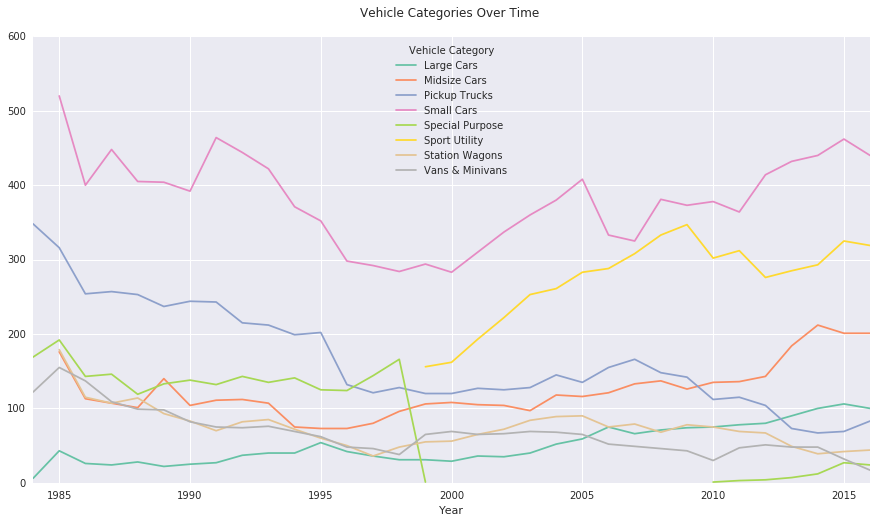

In [53]:
multi_line(vehicles, 'Year', 'Vehicle Category')
ax.set(xlabel='\n Year')
sns.plt.title('Vehicle Categories Over Time \n')

We can see from the chart that Small Cars have generally dominated across the board and that there was a small decline in the late 90s that then started to pick up again in the early 2000s. We can also see the introduction and increase in popularity of SUVs starting in the late 90s, and the decline in popularity of trucks in recent years.

If we wanted to, we could zoom in and filter for specific manufacturers to see how their offerings have changed over the years. Since BMW had the most number of vehicles last year and we saw in the pivot heatmap that those were mostly small cars, let's filter for just their vehicles to see whether they have always made a lot of small cars or if this is more of a recent phenomenon.

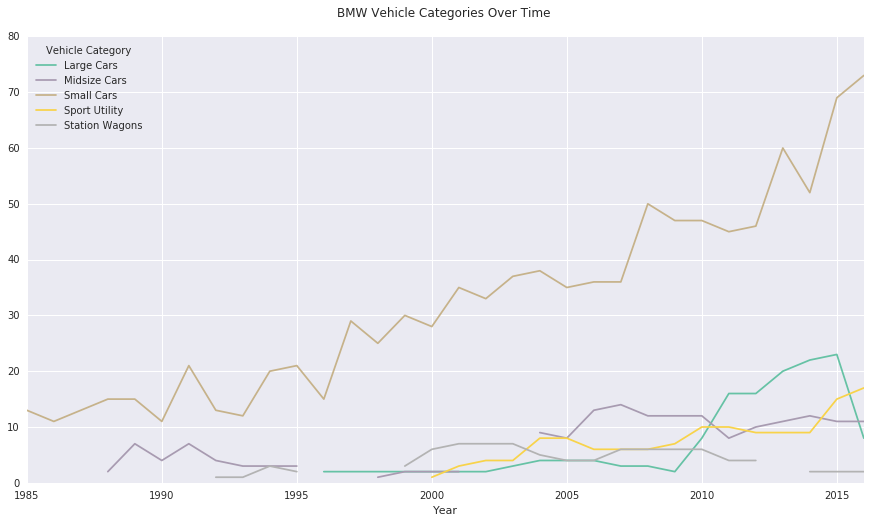

In [54]:
bmw = vehicles[vehicles['Make'] == 'BMW']

multi_line(bmw, 'Year', 'Vehicle Category')
ax.set(xlabel='\n Year')
sns.plt.title('BMW Vehicle Categories Over Time \n')

We can see in the chart above that they started off making a reasonable number of small cars, and then seemed to ramp up production of those types of vehicles in the late 90s. We can contrast this with a company like Toyota, who started out making a lot of small cars back in the 1980s and then seemingly made a decision to gradually manufacture less of them over the years, focusing instead on SUVs, pickup trucks, and midsize cars.

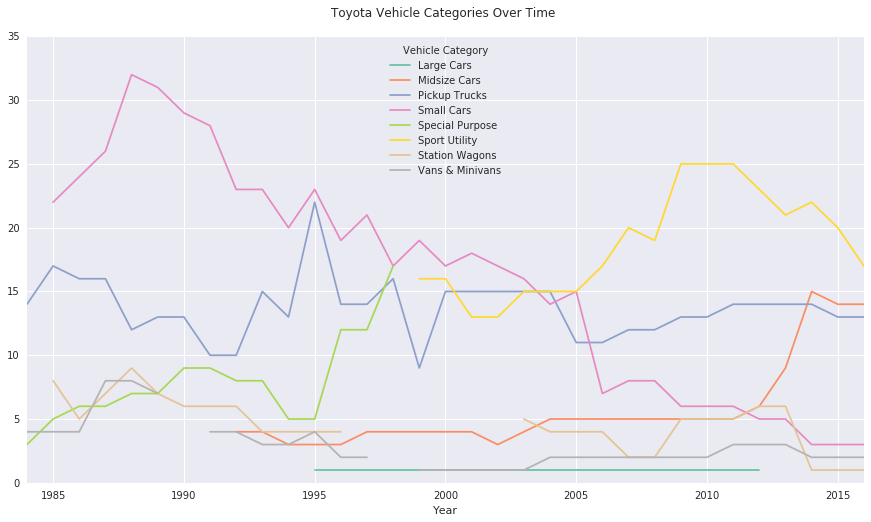

In [55]:
toyota = vehicles[vehicles['Make'] == 'Toyota']

multi_line(toyota, 'Year', 'Vehicle Category')
ax.set(xlabel='\n Year')
sns.plt.title('Toyota Vehicle Categories Over Time \n')

The final way we are going to explore our data in this post is by examining the relationships between numerical variables in our data. Doing this will provide us with better insight into which fields are highly correlated, what the nature of those correlations are, what typical combinations of numerical values exist in our data, and which combinations are anomalies.

For looking at relationships between variables, I often like to start with a scatter matrix because it gives me a bird's eye view of the relationships between all the numerical fields in my data set. With just a couple lines of code, we can not only create a scatter matrix, but we can also factor in a layer of color that can represent, for example, the clusters we generated at the end of the last post.

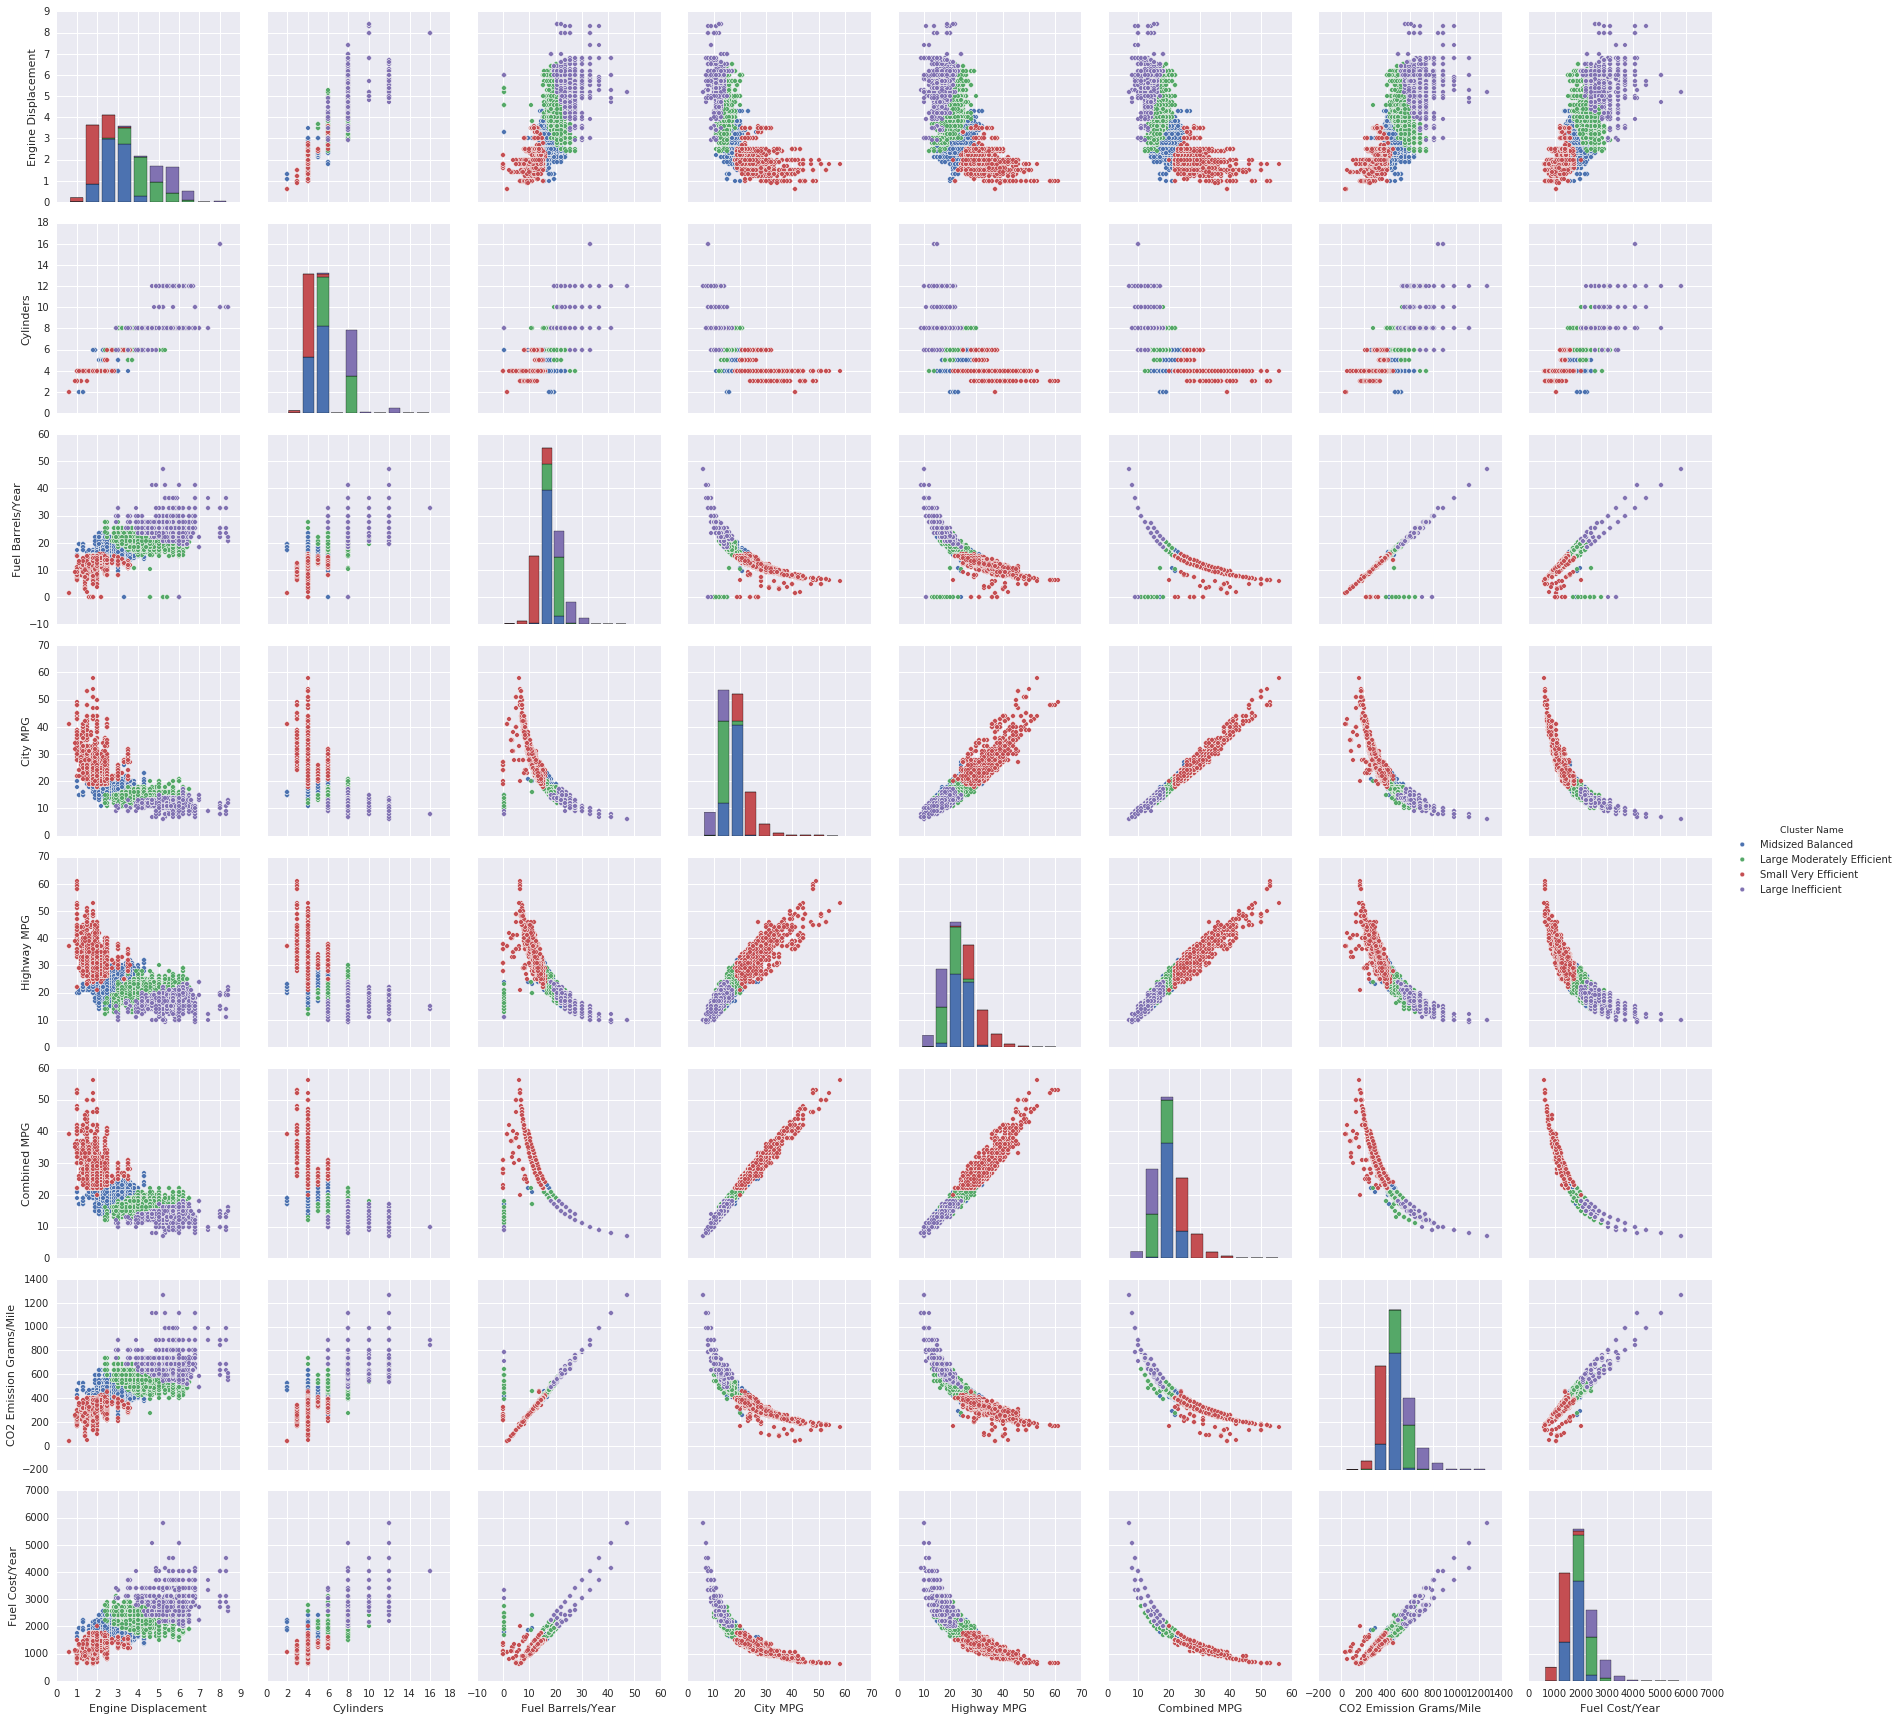

In [56]:
select_columns = ['Engine Displacement','Cylinders','Fuel Barrels/Year',
                   'City MPG','Highway MPG','Combined MPG',
                   'CO2 Emission Grams/Mile', 'Fuel Cost/Year', 'Cluster Name']

sns.pairplot(vehicles[select_columns], hue='Cluster Name', size=3)

From here, we can see that there are some strong positive linear relationships in our data, such as the correlations between the MPG fields, and also among the fuel cost, barrels, and CO2 emissions fields. There are also some hyperbolic relationships in there as well, particularly between the MPG fields and engine displacement, fuel cost, barrels, and emissions. Additionally, we can also get a sense of the size of our clusters, how they are distributed, and the level of overlap we have between them.

Once we have this high-level overview, we can zoom in on anything that we think looks interesting. For example, let's take a closer look at Engine Displacement plotted against Combined MPG.

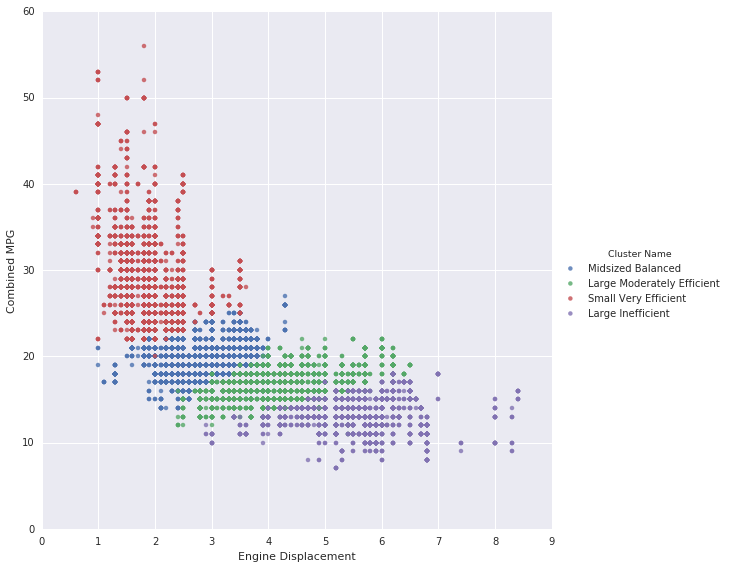

In [57]:
sns.lmplot('Engine Displacement', 'Combined MPG', data=vehicles, 
           hue='Cluster Name', size=8, fit_reg=False)

In addition to being able to see that there is a hyperbolic correlation between these two variables, we can see that our Small Very Efficient cluster resides in the upper left, followed by our Midsized Balanced cluster that looks smaller and more compact than the others. After that, we have our Large Moderately Efficient cluster and finally our Large Inefficient cluster on the bottom right.

We can also see that there are a few red points at the very top left and a few purple points at the very bottom right that we may want to investigate further to get a sense of what types of vehicles we are likely to see at the extremes. Try identifying some of those on your own by filtering the data set like we did earlier in the post. While you're at it, try creating additional scatter plots that zoom in on other numerical field combinations from the scatter matrix above. There are a bunch of other insights to be found in this data set, and all it takes is a little exploration!

We have covered quite a bit in this post, and I hope I've provided you with some good examples of how, with just a few tools in your arsenal, you can embark on a robust insight-finding expedition and discover truly interesting things about your data. Now that you have some structure in your process and some tools for exploring data, you can let your creativity run wild a little and come up with filter, aggregate, pivot, and scatter combinations that are most interesting to you